In [22]:
! pip install corextopic

In [34]:
# Importing Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For Reading data
import pyarrow.parquet as pq

# For Text Cleaning
import re

# For Words Selection
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

# Tokenize the data
from sklearn.feature_extraction.text import CountVectorizer

# Importing CorEx
from corextopic import corextopic as ct

# For Visualizing Topic
from corextopic import vis_topic as vt

# For Converting into NetworkX
import networkx as nx

# Ignoring Warning Messages
import warnings
warnings.filterwarnings("ignore")



---


- First we have downloaded data from the yelp review data from the Hugging face. I have also attached the link of the data we have used. Also I have only used Test Data for this work which contain the 50000 rows.

Dataset- https://huggingface.co/datasets/yelp_review_full/viewer/yelp_review_full/test

---



# Data Exploration

In [3]:
df = pq.read_table(source='/content/drive/MyDrive/Project DS/test-00000-of-00001.parquet').to_pandas()

- Check the content of dataset.

In [4]:
df.head()

,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...


- Check the shape of data.

In [5]:
df.shape

(50000, 2)

---
- Plotted a Pie chart to show the Distribution of labels in the entrity of data. This gives us an better idea of data and also helps in deciding the further process to follow on the basis of distribution.
---



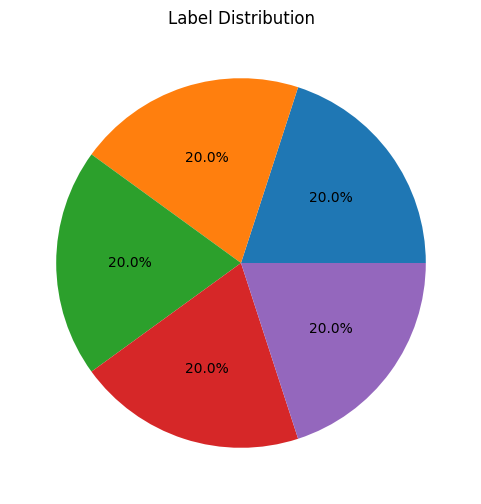

In [6]:
plt.figure(figsize=(6,6))
contri = df['label'].value_counts()
plt.pie(contri, autopct= '%1.1f%%')
plt.title('Label Distribution')
plt.show();

---
- As shown through the pie chart that the data distribution is balanced on the entirity of data, through this we can conclude that

 - No, need to balanced the data in further steps.
 - We don't have to face much problem in classification as all the classes are in balanced which will help train the data more efficiently.
---

# Data Reduction

---
- But as Suggested in the task we need to take a small dataset but the size of this data is very large and hence we need to drop some rows of the data to make it more feasible in the provided range.
---
---
- Since the minimum count of data needs to be 20 and our data is already at 50000 so I thought of reducing it to 100 but also at the same time keeping the labels balanced.
---

- Split the data by label to ensure balance

In [7]:
dfs_by_label = [df[df['label'] == label] for label in df['label'].unique()]

- Reduce the size of each subset to 20 samples

In [8]:
df_resized = [df_label.sample(n=20, random_state=42) for df_label in dfs_by_label]

- Concatenate the resized subsets back into a single DataFrame

In [9]:
df_new = pd.concat(df_resized, ignore_index=True)

- Shuffle the DataFrame to mix labels

In [10]:
df_final = df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df_final

,label,text
0,4,fantastic! what air travel should be. a quick...
1,1,Show me someone who hates Boots and I'll show ...
2,3,My husband and I loved this place. The staff w...
3,1,So disappointing. I was expecting so much but...
4,1,I just moved into the neighborhood and was try...
...,...,...
95,3,"I have only been to MADCAP once, to see \""Unti..."
96,3,J'y suis all\u00e9 pour \u00e9couter une game ...
97,0,7/15/2014 6:30 PM\nParty of three: nice waitre...
98,4,"Yelp steered me here, and it sure didn't steer..."


- Check the shape of resulting DataFrame

In [12]:
df_final.shape

(100, 2)

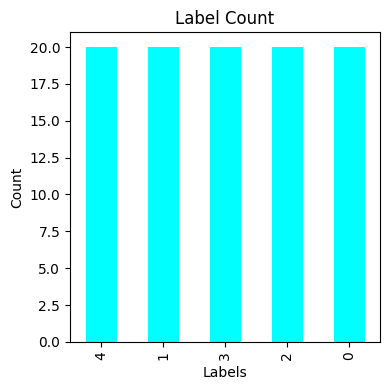

In [13]:
plt.figure(figsize=(4,4))
df_final['label'].value_counts().plot(kind='bar', color='cyan')
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Data Cleaning

---
Now, as we have made our data, the first step is to clean our text to get the hierarchial topics with ease without any noise.

In [14]:
import string

def remove_noise(text):
    text = re.sub("(@[A-Za-z0–9_]+)","", text)
    text = "".join([char if char not in string.punctuation else " "  for char in text])
    text = re.sub(' +', ' ', text)
    text = re.sub("\'", "", text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\S*@\S*\s?', '', text)

    return text

df_final['cln_text'] = df_final['text'].apply(lambda x: remove_noise(x))
df_final

,label,text,cln_text
0,4,fantastic! what air travel should be. a quick...,fantastic what air travel should be a quick da...
1,1,Show me someone who hates Boots and I'll show ...,Show me someone who hates Boots and I ll show ...
2,3,My husband and I loved this place. The staff w...,My husband and I loved this place The staff wa...
3,1,So disappointing. I was expecting so much but...,So disappointing I was expecting so much but m...
4,1,I just moved into the neighborhood and was try...,I just moved into the neighborhood and was try...
...,...,...,...
95,3,"I have only been to MADCAP once, to see \""Unti...",I have only been to MADCAP once to see Until t...
96,3,J'y suis all\u00e9 pour \u00e9couter une game ...,J y suis all u00e9 pour u00e9couter une game d...
97,0,7/15/2014 6:30 PM\nParty of three: nice waitre...,7 15 2014 6 30 PM nParty of three nice waitres...
98,4,"Yelp steered me here, and it sure didn't steer...",Yelp steered me here and it sure didn t steer ...


---
Here we can see the difference between the clean text and original text clealry and can witness the clean text is more topic oriented.

# Hierarchial Word Selection through WordCloud

---
- Now to explore and make hierarachial topics, I am going to plot a word cloud which will give me basic idea and most used word for each review category
---

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

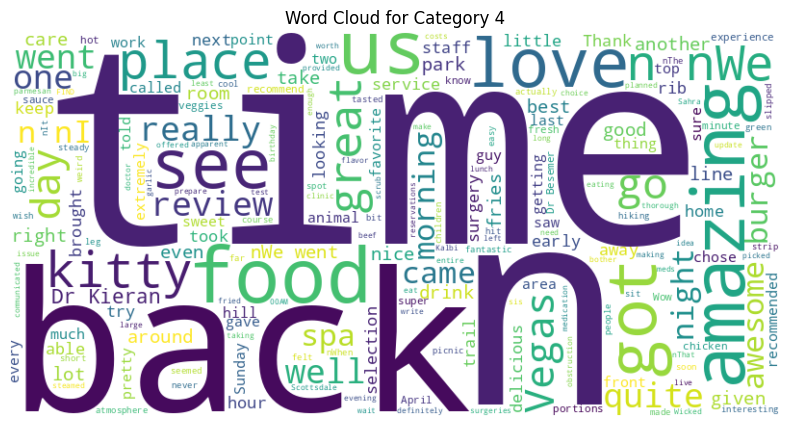

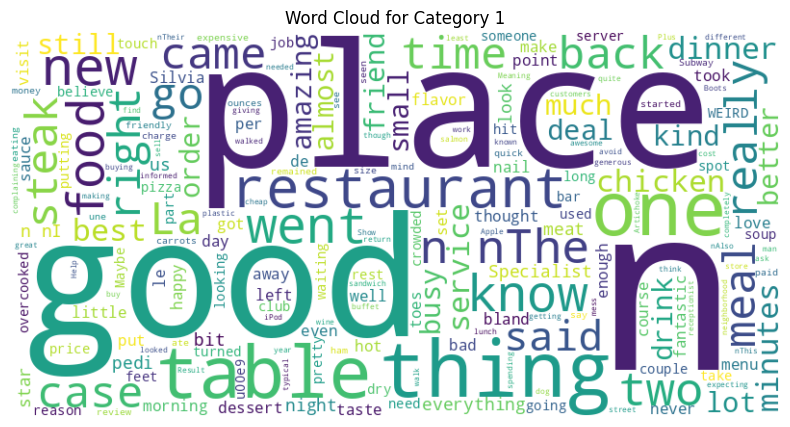

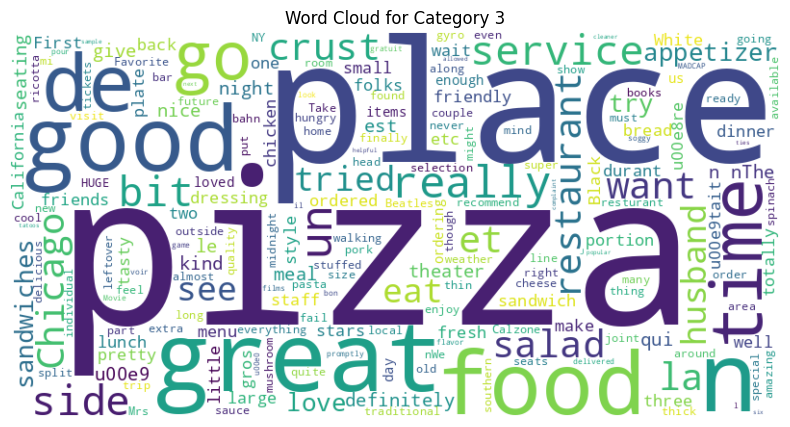

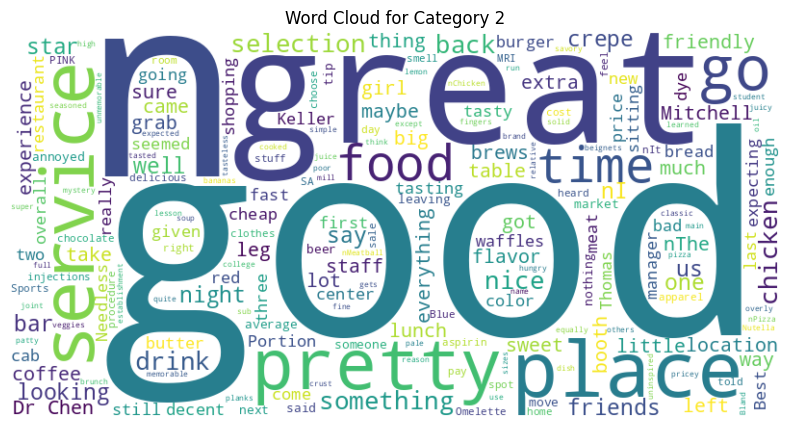

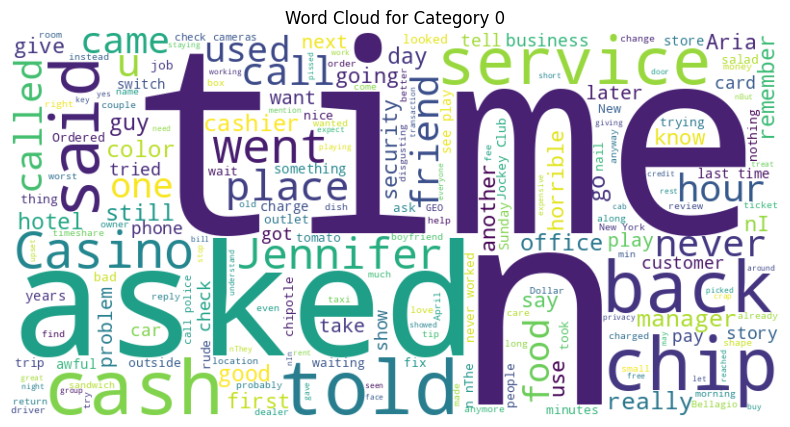

In [16]:
categories = df_final['label'].unique()
all_stopwords = set(stopwords.words('english'))

for category in categories:
    # Filter data for the specific category
    category_data = df_final[df_final['label'] == category]

    # Concatenate all the text in the category
    text = ' '.join(category_data['cln_text'])

    cleaned_text = ' '.join([word for word in text.split() if word.lower() not in all_stopwords])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(cleaned_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category {category}')
    plt.axis('off')
    plt.show()

---
- As we can see that in these worclouds there are some words which are repeatting in all the labels because of which it is very difficult to pick the right hierarchial topics, so Now we will add some custome keywords along with the usual Stopwords.
---

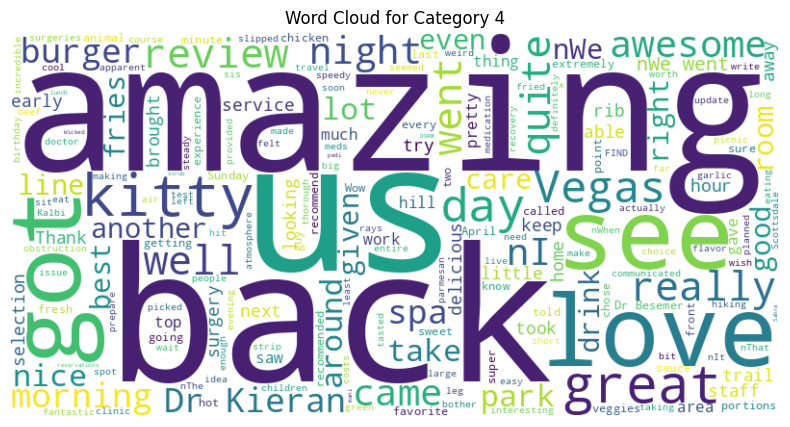

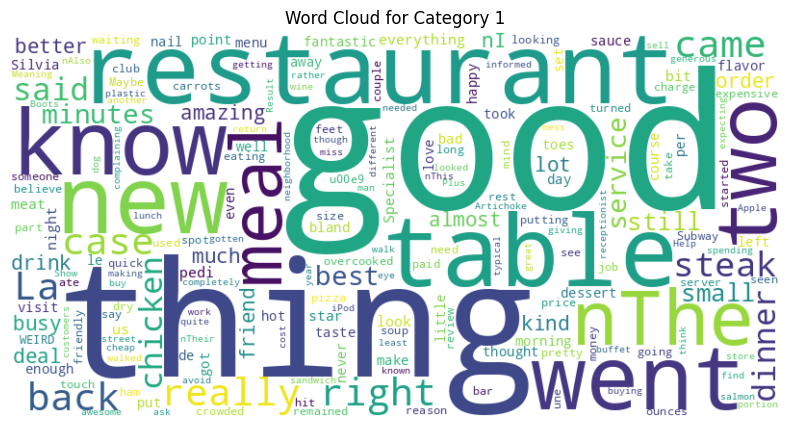

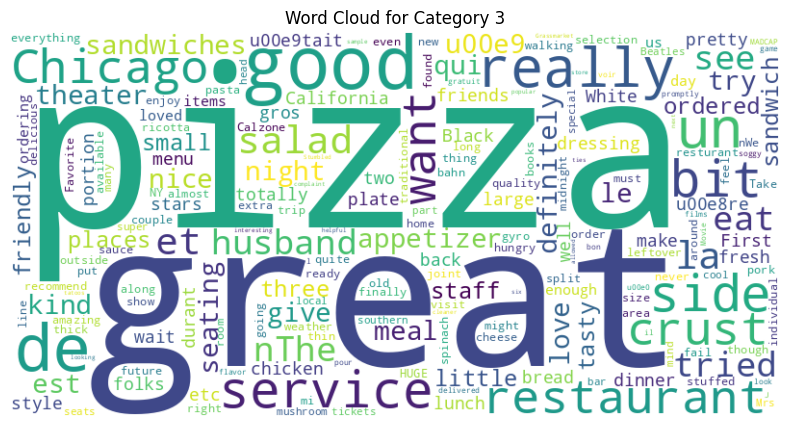

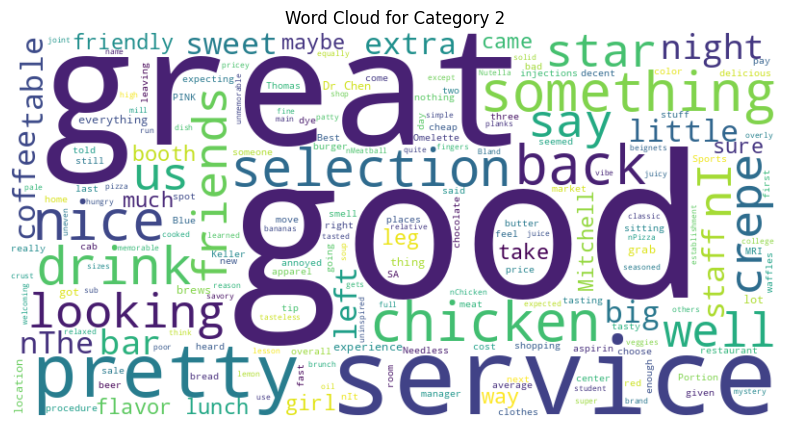

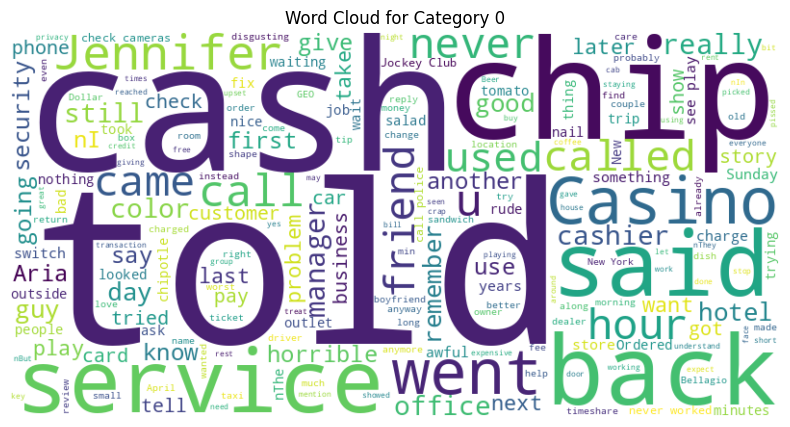

In [17]:
custom_stopwords = set(["place", "food", "time", "one", "go", "n", "asked"])

# Combine NLTK stopwords, custom stopwords, and WordCloud default stopwords
all_stopwords = set(stopwords.words('english')).union(STOPWORDS, custom_stopwords)

categories = df_final['label'].unique()

for category in categories:
    # Filter data for the specific category
    category_data = df_final[df_final['label'] == category]

    # Concatenate all the text in the category
    text = ' '.join(category_data['cln_text'])

    # Remove stopwords
    cleaned_text = ' '.join([word for word in text.split() if word.lower() not in all_stopwords])

    # Generate word cloud using cleaned text
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords, random_state=42).generate(cleaned_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category {category}')
    plt.axis('off')
    plt.show()

---
- Now we are going to assign hierarchial words for each rating in the data on the basis of frequent words seen in the word cloud.
---

In [18]:
hier_rev_0 = ['never', 'waiting', 'problem', 'casino', 'service']
hier_rev_1 = ['good', 'new', 'minutes', 'service', 'restaurant']
hier_rev_2 = ['great', 'friendly', 'good', 'pretty', 'service']
hier_rev_3 = ['great', 'love', 'reataurant', 'friendly', 'service']
hier_rev_4 = ['amazing', 'awesome', 'love', 'great', 'best']

---
- Making a Dictionary for the hierarchial words.
---

In [19]:
hierarchical_words_dict = {
    0: hier_rev_0,
    1: hier_rev_1,
    2: hier_rev_2,
    3: hier_rev_3,
    4: hier_rev_4
}

---
# Preparing the data for the CorEx Model
---

In [21]:
# Combine hierarchical words for all labels
all_hierarchical_words = [word for words in hierarchical_words_dict.values() for word in words]

# Get unique labels
labels = df_final['label'].unique()

# Prepare data for CorEx model
X = df_final['cln_text'].values

vectorizer = CountVectorizer()
X_matrix = vectorizer.fit_transform(X)

---
- Installing CorEx

---
- Initializing the CorEx model and fitting it with the anchor words
---

In [37]:
# Initialize CorEx model
topic_model = ct.Corex(n_hidden=len(all_hierarchical_words), seed=42)

# Fit the CorEx model with hierarchical words as anchors
topic_model.fit(X_matrix, words=all_hierarchical_words, anchors=[['love','awesome'], 'great'], anchor_strength=3.0)

---
- Retrieving topics from topic model then formatting them with associated information and then finally printing each tpic word with sign.
---

In [24]:
topics = topic_model.get_topics()
for topic_n, topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(str(w), mi, s) if s > 0 else ('~'+str(w), mi, s) for w, mi, s in topic]
    words, mis, signs = zip(*topic)
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)


1: 21, 274, 2020, 2652, 2106, 2308, 1212, 746, 559, 2049
2: 943, 2513, 276, 2103, 741, 857, 1950, 1283, 23, 2100
3: 2412, 1529, 2102, 132, 2088, 1465, 1948, 1338, 571, 1466
4: 1978, 1765, 2546, 1098, 2368, 567, 1601, 408, 1871, 2055
5: 1012, ~1989, ~244, ~562, ~1502, ~1472, ~2119, ~2212, ~1304, ~2099
6: 1270, 2603, 2358, 1268, 992, 2450, 2117, 2542, 2523, 509
7: 2140, 1420, 2455, 2122, 824, 2376, 1191, 2232, 1607, 2559
8: 1258, 340, 665, 2580, 1337, 704, 1532, 627, 467, 2220
9: 2606, 371, 968, 2597, 58, 114, 2222, 1745, 1606, 380
10: 1859, 566, 972, 2537, 2501, 805, 790, 724, 1017, 1031
11: 1852, 2025, 166, 1647, 739, 1396, 675, 2381, 1744, 1774
12: 245, 1723, 2443, 561, 186, 1779, 1350, 1702, 1902, 1059
13: 111, 253, 2411, 2600, 624, 2442, 1575, 859, 2366, 884
14: 2372, 2354, 662, 1628, 1545, 1671, 1489, 1307, 2151, 81
15: 125, 712, 1345, 1551, 2666, 942, 366, 158, 1316, 1107
16: 2322, 1721, 1376, 825, 2303, 2279, 310, 936, 874, 2120
17: 2657, 2002, 1108, 735, 2194, 2010, 1883, 267, 2

---
- Getting top documents for each topic from a topic model and then prints associated hierarchial words for each topic.
---

In [41]:
top_docs = topic_model.get_top_docs()
for topic_n, topic_docs in enumerate(top_docs):
    docs,probs = zip(*topic_docs)
    topic_str = str(topic_n+1)+': '+', '.join(all_hierarchical_words)
    print(topic_str)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
1: never, waiting, problem, casino, service, good, new, minutes, service, restaurant, great, friendly, good, pretty, service, great, love, reataurant, friendly, service, amazing, awesome, love, great, best
2: never, waiting, problem, casino, service, good, new, minutes, service, restaurant, great, friendly, good, pretty, service, great, love, reataurant, friendly, service, amazing, awesome, love, great, best
3: never, waiting, problem, casino, service, good, new, minutes, service, restaurant, great, friendly, good, pretty, service, great, love, reataurant, friendly, service, amazing, awesome, love, great, best
4: never, waiting, problem, casino, service, good, new, minutes, service, restaurant, great, friendly, good, pretty, service, great, love, reataurant, friendly, service, amazing, awesome, love, great, best
5: never, waiting, problem, casino, service, good, new, minutes, service, restaurant, great, frie

 ## Building Hierarchial Topic Model

In [31]:
# Layer 1
topic_model = ct.Corex(n_hidden=100)
topic_model.fit(X_matrix)
# Layer 2
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels)
# Layer 3
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels)
# getting features
words = vectorizer.get_feature_names_out()
hierarchical_graph = vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=50, prefix='topic-model-example')

weight threshold is 0.119427 for graph with max of 50.000000 edges 


---
- Converted hierarchial graph to  directed netowrkX graph.
---

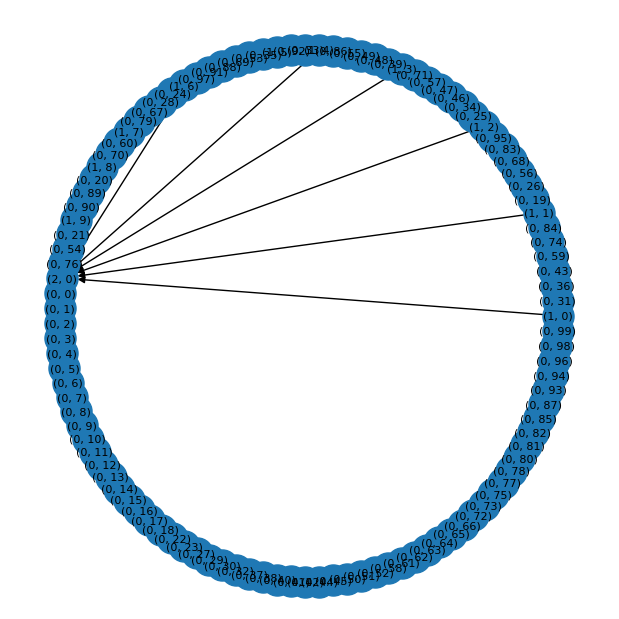

In [71]:
# Convert the hierarchical graph to a networkx graph
graph = nx.DiGraph(hierarchical_graph)

# Visualize the graph
plt.figure(figsize=(6,6))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, with_labels=True, font_size=8, node_size=500, font_color='black', font_family='sans-serif')
plt.show()

---
- Making Function to calculate NPMI
---

In [49]:
def calculate_npmi(corpus_matrix1, corpus_matrix2):
    # Calculate co-occurrence matrix
    co_occurrence_matrix = np.dot(corpus_matrix1.T, corpus_matrix2)

    # Calculate marginal probabilities
    p_x = np.sum(corpus_matrix1, axis=0) / len(corpus_matrix1)
    p_y = np.sum(corpus_matrix2, axis=0) / len(corpus_matrix2)

    # Calculate pointwise mutual information (PMI)
    pmi_matrix = np.log2((co_occurrence_matrix * len(corpus_matrix1)) / (np.outer(p_x, p_y) + 1e-12))

    # Calculate normalized pointwise mutual information (NPMI)
    npmi_matrix = pmi_matrix / (-np.log2(np.outer(p_x, p_y)) + 1e-12)

    # Set the diagonal elements to zero (not considering self-cooccurrence)
    np.fill_diagonal(npmi_matrix, 0)

    return npmi_matrix


---
- Calculating Average NPMI for each topic.
---

In [64]:
# Calculate NPMI for each layer
npmi_layer1 = calculate_npmi(X_matrix.toarray(), topic_model.labels)
npmi_layer2 = calculate_npmi(topic_model.labels, tm_layer2.labels)
npmi_layer3 = calculate_npmi(tm_layer2.labels, tm_layer3.labels)
npmi_layer1_trimmed = npmi_layer1[:25, :10]
npmi_layer2_trimmed = npmi_layer2[:, :10]

small_constant = -1
npmi_layer1_trimmed[npmi_layer1_trimmed == -np.inf] = small_constant
npmi_layer2_trimmed[npmi_layer2_trimmed == -np.inf] = small_constant

# Calculate average NPMI along the axis representing topics
average_npmi = np.mean([npmi_layer1_trimmed, npmi_layer2_trimmed], axis=0)

# Print average NPMI for each topic
for i, avg_npmi in enumerate(average_npmi):
    print(f'Average NPMI for Topic {i+1}: {avg_npmi}')

# Print overall average NPMI
overall_avg_npmi = np.mean(average_npmi)
print(f'Overall Average NPMI: {overall_avg_npmi}')



Average NPMI for Topic 1: [0.         2.43965808 2.27597399 2.27413828 2.51701354 2.38728703
 0.77067165 0.74250764 2.25307055 0.67138652]
Average NPMI for Topic 2: [2.28632772 0.         0.79785167 2.30373925 2.44736782 2.41611482
 0.77067165 2.22230071 2.21035348 2.14219561]
Average NPMI for Topic 3: [0.95227004 1.11540122 0.         0.95227004 2.41719583 1.05776794
 0.89168028 0.85419255 2.1916114  0.7614037 ]
Average NPMI for Topic 4: [0.87791427 1.01473449 0.85747436 0.         2.34462585 0.96681127
 0.82616    0.79387931 0.74886284 2.07744662]
Average NPMI for Topic 5: [1.72891907 3.7183165  1.65139588 3.10520163 0.         3.51204149
 1.53904879 1.43067656 2.68014936 1.18815997]
Average NPMI for Topic 6: [2.6298898  2.82108517 2.77949745 2.65901162 2.99982142 0.
 0.954479   2.57974575 2.60764336 2.33314493]
Average NPMI for Topic 7: [0.79933678 2.32041652 0.78235668 0.79933678 2.34771834 0.87237062
 0.         2.20886272 0.69092658 0.66038047]
Average NPMI for Topic 8: [0.847130